In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pylab import rcParams
import calendar
from datetime import datetime, timedelta
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
def days_in_month(dt):
    return calendar.monthrange(dt.year, dt.month)[1]


def monthly_range(dt_start, dt_end):
    forward = dt_end >= dt_start
    finish = False
    dt = dt_start

    while not finish:
        yield dt
        if forward:
            days = days_in_month(dt)
            dt = dt + timedelta(days=days)
            finish = dt > dt_end
        else:
            _tmp_dt = dt.replace(day=1) - timedelta(days=1)
            dt = (_tmp_dt.replace(day=dt.day))
            finish = dt < dt_end

rcParams['figure.figsize'] = 16,4
df = pd.read_csv('database.csv', low_memory=False)
df.head()

,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [3]:
df.Month = pd.to_datetime(df.Month, format='%B').dt.month.map("{:02}".format)
df['Date'] = df.apply(lambda row: '{}-{}'.format(row.Year, row.Month), axis=1)
df.reset_index()
df.Date = pd.to_datetime(df.Date, format='%Y-%m')

states = df[['Date', 'State', 'Incident']]
states = states.groupby(['Date', 'State'])['Incident'].sum().unstack()
states = states.fillna(0)

In [9]:
my_series = pd.DataFrame()
i = 0
for state in list(states):
    my_series[state] = states[states.columns[i]]
    i += 1
my_series.head()

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,119.0,1.0,105.0,39.0,2992.0,20.0,15.0,4.0,190.0,438.0,...,0.0,112.0,1642.0,6.0,1.0,44.0,30.0,10.0,17.0,1.0
1980-02-01,63.0,8.0,75.0,21.0,2526.0,54.0,7.0,30.0,120.0,283.0,...,1.0,140.0,2077.0,9.0,1.0,40.0,14.0,13.0,40.0,3.0
1980-03-01,103.0,3.0,49.0,19.0,2346.0,16.0,24.0,2.0,91.0,385.0,...,0.0,124.0,3426.0,4.0,0.0,60.0,30.0,6.0,71.0,3.0
1980-04-01,72.0,4.0,106.0,55.0,3743.0,39.0,49.0,5.0,105.0,272.0,...,0.0,177.0,1908.0,1.0,0.0,49.0,38.0,4.0,23.0,2.0
1980-05-01,78.0,4.0,70.0,29.0,2854.0,76.0,10.0,1.0,153.0,1143.0,...,2.0,234.0,2065.0,6.0,0.0,63.0,44.0,17.0,22.0,1.0


In [13]:
# Transform to time series into time series of equal length

state_names = states.columns.values.tolist()

date_start = datetime(1979, 1, 1)
date_end = datetime(2015, 1, 1)

series_dict = dict()
for state in state_names:
    series_dict[state] = dict()


for p in monthly_range(date_start, date_end):
    for state in series_dict:
        series_dict[state][p] = 0.0

for state in my_series:
    d = my_series[state].to_dict()
    for t in d:
        series_dict[state][t] = d[t]

series = []
for state in series_dict:
    data = sorted(series_dict[state].items())
    seq = [v for k, v in data] #[300:] #ToDo
    series.append(seq)

series = np.array(series)
series[:5]

array([[   0.,    0.,    0., ...,    2.,    6.,    0.],
       [   0.,    0.,    0., ...,  424.,  114.,    0.],
       [   0.,    0.,    0., ...,   20.,   20.,    0.],
       [   0.,    0.,    0., ...,    4.,   16.,    0.],
       [   0.,    0.,    0., ...,  568.,  743.,    0.]])

In [14]:
# K-means cluster analysis for 1-10 clusters due to the 10 possible class outcomes for poker hands

clusters=range(1, 10)
meandist=[]

# Loop through each cluster and fit the model to the train set
# generate the predicted cluster assingment and append the mean distance my taking the sum divided by the shape

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(series)
    clusassign=model.predict(series)
    meandist.append(sum(np.min(cdist(series, model.cluster_centers_, 'euclidean'), axis=1))
    / series.shape[0])

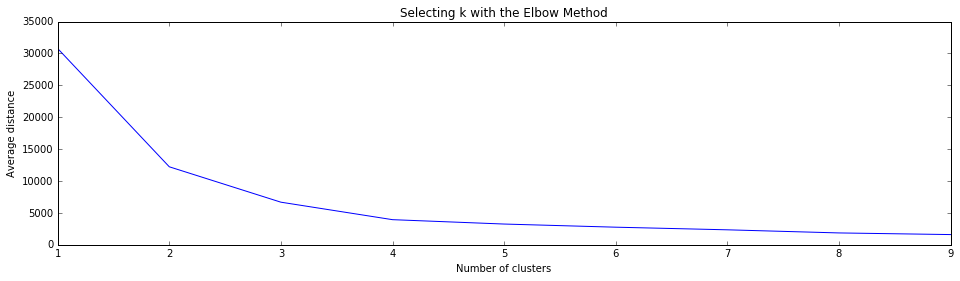

In [16]:
# Choose the best cluster number with Elbow rule

"""
Plot average distance from observations from the cluster centroid
to use the Elbow Method to identify number of clusters to choose
"""
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method') # pick the fewest number of clusters that reduces the average distance
plt.show()

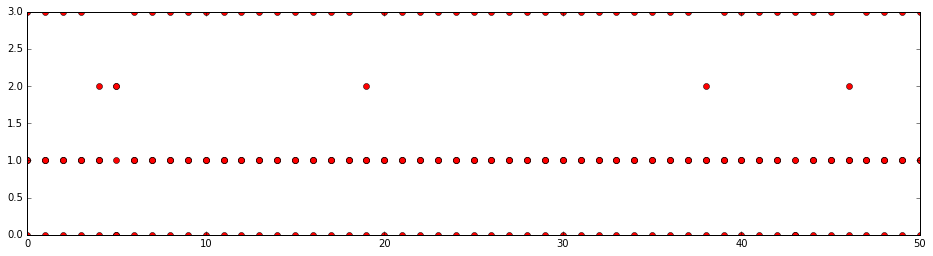

In [27]:
num_clusters = 4
km = KMeans(n_clusters=num_clusters, init='random') # k-means++ random
km.fit(series)
plt.plot(km.labels_, 'ro')
plt.show()

In [28]:
labels = km.predict(series)
labels

array([3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 0, 3, 3,
       1, 3, 3, 3, 3], dtype=int32)

In [37]:
clusters = dict()
for i in range(0, num_clusters):
    clusters[i] = []

for i in range(0, 51):
    clusters[labels[i]].append(state_names[i] + ' (' + str(i) + ') ')

clusters

{0: ['Texas (43) '],
 1: ['California (4) ', 'Maine (19) ', 'Pennsylvania (38) ', 'Virginia (46) '],
 2: ['Colorado (5) '],
 3: ['Alabama (0) ',
  'Alaska (1) ',
  'Arizona (2) ',
  'Arkansas (3) ',
  'Connecticut (6) ',
  'Delaware (7) ',
  'District of Columbia (8) ',
  'Florida (9) ',
  'Georgia (10) ',
  'Hawaii (11) ',
  'Idaho (12) ',
  'Illinois (13) ',
  'Indiana (14) ',
  'Iowa (15) ',
  'Kansas (16) ',
  'Kentucky (17) ',
  'Louisiana (18) ',
  'Maryland (20) ',
  'Massachusetts (21) ',
  'Michigan (22) ',
  'Minnesota (23) ',
  'Mississippi (24) ',
  'Missouri (25) ',
  'Montana (26) ',
  'Nebraska (27) ',
  'Nevada (28) ',
  'New Hampshire (29) ',
  'New Jersey (30) ',
  'New Mexico (31) ',
  'New York (32) ',
  'North Carolina (33) ',
  'North Dakota (34) ',
  'Ohio (35) ',
  'Oklahoma (36) ',
  'Oregon (37) ',
  'Rhodes Island (39) ',
  'South Carolina (40) ',
  'South Dakota (41) ',
  'Tennessee (42) ',
  'Utah (44) ',
  'Vermont (45) ',
  'Washington (47) ',
  'West Vir

In [38]:
series[43]

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         1.15860000e+04,   8.14500000e+03,   8.12500000e+03,
         1.13560000e+04,   1.03650000e+04,   1.26040000e+04,
         1.14350000e+04,   1.62110000e+04,   7.90000000e+01,
         2.03530000e+04,   1.10670000e+04,   2.89970000e+04,
         1.42760000e+04,   7.43300000e+03,   1.27860000e+04,
         1.10720000e+04,   8.73200000e+03,   2.73000000e+02,
         1.62310000e+04,   8.02900000e+03,   1.56160000e+04,
         1.24210000e+04,   1.65300000e+04,   3.00000000e+01,
         8.31100000e+03,   1.00530000e+04,   9.89400000e+03,
         9.08400000e+03,   1.52890000e+04,   1.39700000e+04,
         1.30540000e+04,   9.51800000e+03,   1.46800000e+04,
         1.24700000e+04,   8.63500000e+03,   6.50000000e+01,
         6.46800000e+03,

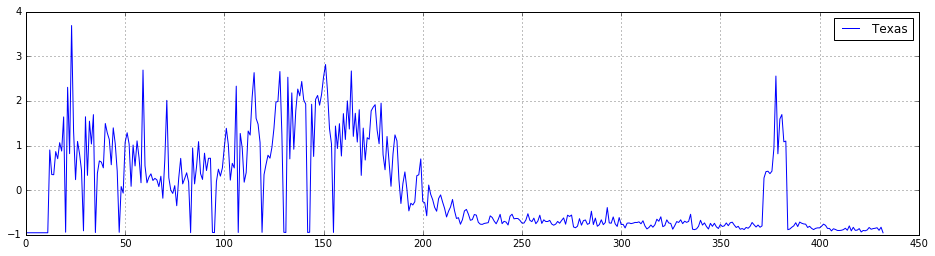

In [60]:
i = 0
for state in list(states):
    my_series[state] = states[states.columns[i]]
    i += 1
fig = plt.figure()
ax = plt.subplot(111)
ax.plot((series[43] - series[43].mean())/series[43].std(), linestyle='ro', label="Texas")
plt.legend(loc='best')
plt.grid()
plt.show()

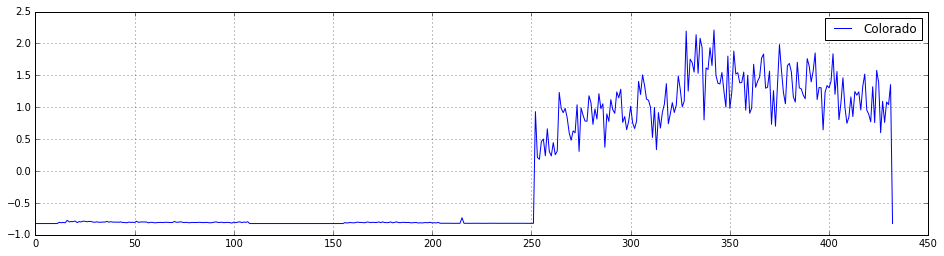

In [61]:
i = 0
for state in list(states):
    my_series[state] = states[states.columns[i]]
    i += 1
fig = plt.figure()
ax = plt.subplot(111)
ax.plot((series[5] - series[5].mean())/series[5].std(), label="Colorado")
plt.legend(loc='best')
plt.grid()
plt.show()

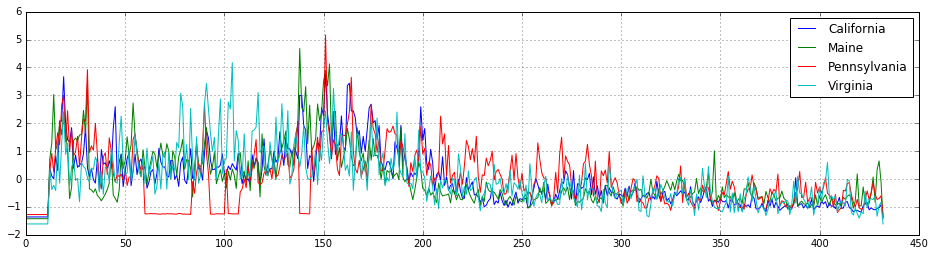

In [62]:
i = 0
for state in list(states):
    my_series[state] = states[states.columns[i]]
    i += 1
fig = plt.figure()
ax = plt.subplot(111)
ax.plot((series[4] - series[4].mean())/series[4].std(), label="California")
ax.plot((series[19] - series[19].mean())/series[19].std(), label="Maine")
ax.plot((series[38] - series[38].mean())/series[38].std(), label="Pennsylvania")
ax.plot((series[46] - series[46].mean())/series[46].std(), label="Virginia")
plt.legend(loc='best')
plt.grid()
plt.show()

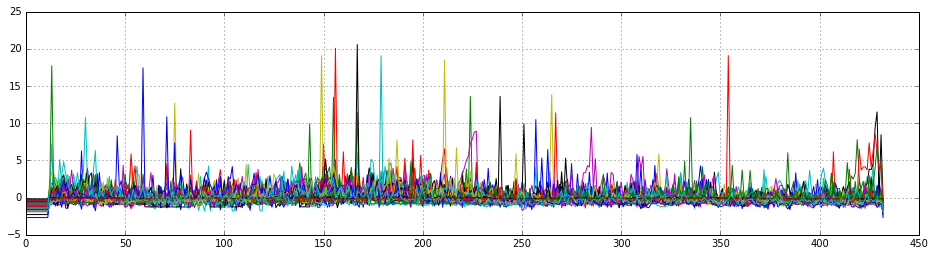

In [68]:
i = 0
for state in list(states):
    my_series[state] = states[states.columns[i]]
    i += 1
fig = plt.figure()
ax = plt.subplot(111)
for i in range(1, 3):
    ax.plot((series[i] - series[i].mean())/series[i].std())
for i in range(6, 50):
    ax.plot((series[i] - series[i].mean())/series[i].std())
plt.grid()
plt.show()